In [1]:
import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)
from torch import tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
from tqdm import tqdm
import pandas as pd


from clipppy import load_config, Clipppy
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML

import swyft
import pyro.distributions as dist

import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')

import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *

plt.rcParams.update({'font.size': 20})

from utils import *

from network import UNET, CustomHead

DEVICE = 'cuda'

In [2]:
m = 10
nsub = 1
nsim = 10000

lr = 1e-6
factor = 3e-4
patience = 5

In [3]:
SYSTEM_NAME = "ngc4414"

RUN = f'_m{m}_nsub{nsub}_nsim{nsim}'
SIM_PATH = f'/nfs/scratch/eliasd/store{RUN}.zarr' 

save_name, save_path = get_name(RUN, lr, factor, patience)

print(RUN)

assert os.path.exists(f'/nfs/scratch/eliasd/store{RUN}.sync')
assert os.path.isfile(save_path)

_m10_nsub1_nsim10000


In [4]:
store = swyft.DirectoryStore(path=SIM_PATH)
print(f'Store has {len(store)} simulations')

Loading existing store.
Store has 10056 simulations


In [5]:
def get_losses(post):
        
    keys = list(post._ratios.keys())
    assert len(keys) == 1
    losses = post._ratios[keys[0]]._train_diagnostics
    assert len(losses) == 1
    tl = losses[0]['train_loss']
    vl = losses[0]['valid_loss']
    epochs = np.arange(len(tl))
    return epochs, tl, vl

def plot_losses(post, title = ''):
    fig, ax = plt.subplots(1, 1)
    
    epochs, tl, vl = get_losses(post)
        
    ax.plot(epochs, tl, '--', label = f'training loss')
    ax.plot(epochs, vl, '-', label = f'val loss')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    plt.legend()
    plt.show()

In [6]:
post = swyft.Posteriors.load(save_path).to(DEVICE)

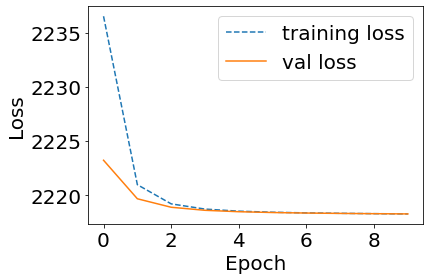

In [7]:
plot_losses(post)

In [8]:
uuu = UNET(1, 1)

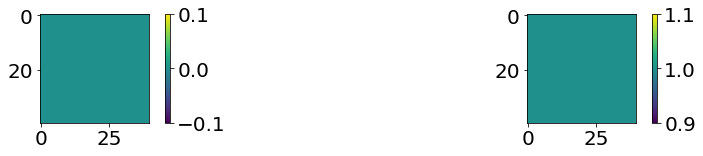

In [9]:
L = 40
grid = torch.linspace(0,(L-1)/L,L)
x, y = torch.meshgrid(grid, grid, indexing = 'xy')
xy_full = torch.transpose(torch.stack((x.flatten(), y.flatten())), 0, 1).flatten()
xy_empty = tensor(())

plots = [uuu.coord_to_map(xy.view(1, -1).to(DEVICE)).cpu().squeeze() for xy in [xy_empty, xy_full]]
plt_imshow(plots, cbar = True, size_y = 2)

In [10]:
def ratio(w):
    r = np.zeros((L**2))
    for i, (key, value) in enumerate(w.items()):
        r[i] = value
    return r.T.reshape(L, L)

def get_ratio(post, obs0, coords):
    samples = post.sample_elias(N = 1, obs0 = (obs0), n_batch = 1, v = coords.view(1, -1))
    v = samples['v']
    w = samples['weights']
    return ratio(w)

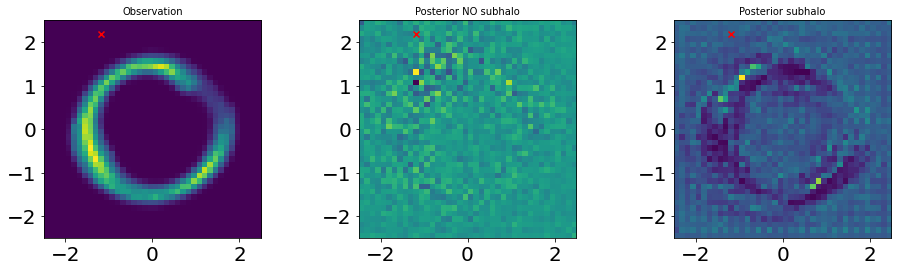

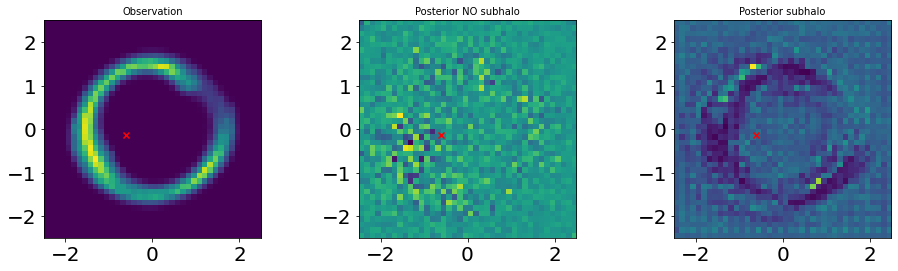

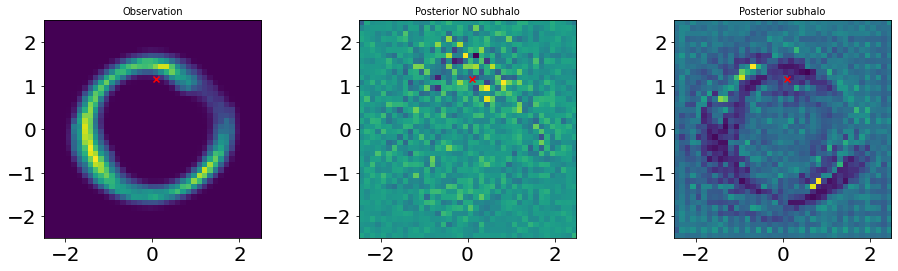

In [11]:
p_1s = []
v0s  = []
for i in np.random.randint(0, len(store), 3):
    obs0 = store[i][0]
    v0 = store[i][1]
    
    p_0 = get_ratio(post, obs0, xy_empty)/(L*L)
    p_1 = get_ratio(post, obs0, xy_full)/(L*L)
    
    plots = [obs0['image'], p_0, p_1]
    plt_imshow(plots, titles = ['Observation', 'Posterior NO subhalo', 'Posterior subhalo'], scatter = [v0]*len(plots), size_y = 4, **imkwargs)
        
    p_1s.append(p_1)
    v0s.append(v0)
    
    
    plt.show()
        

# Play around

In [12]:
get_losses(post)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [2236.5278441517066,
  2220.970490151263,
  2219.198417068373,
  2218.717267841312,
  2218.5234513519504,
  2218.4252721908247,
  2218.365275930851,
  2218.3247884114585,
  2218.294669076906,
  2218.270928565492],
 [2223.227001953125,
  2219.6690266927085,
  2218.88525390625,
  2218.604280598958,
  2218.473323567708,
  2218.3995279947917,
  2218.3507486979165,
  2218.317203776042,
  2218.291080729167,
  2218.270361328125])

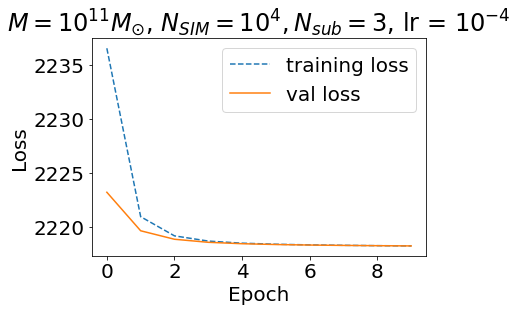

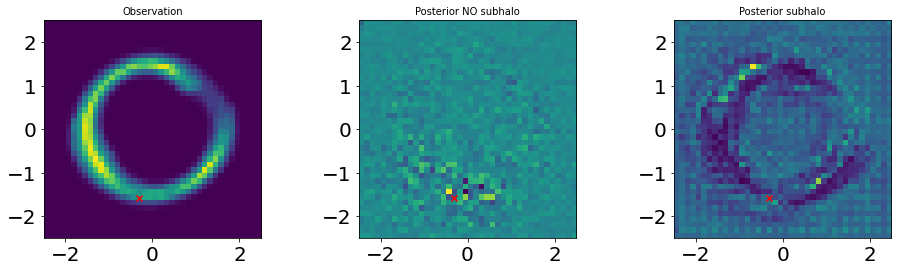

In [13]:
plot_losses(post, r'$M = 10^{11} M_{\odot}$, $N_{SIM} = 10^{4}, N_{sub} = 3$, lr = $10^{-4}$')

for i in np.random.randint(0, len(store), 1):
    obs0 = store[i][0]
    v0 = store[i][1]
    
    p_0 = get_ratio(post, obs0, xy_empty)/(L*L)
    p_1 = get_ratio(post, obs0, xy_full)/(L*L)
    
    plots = [obs0['image'], p_0, p_1]
    plt_imshow(plots, titles = ['Observation', 'Posterior NO subhalo', 'Posterior subhalo'], scatter = [v0]*len(plots), size_y = 4, **imkwargs)    
    
    plt.show()